In [9]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa

import numpy as np
import pandas as pd
!pip install ujson
import ujson as json
from pathlib import Path

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

BASEPATH = Path('../input/herbarium-2021-fgvc8/train')

# Let's read metadata.json

In [10]:
train_meta = '../input/herbarium-2021-fgvc8/train/metadata.json'

with open(train_meta, 'r') as json_file:
    train_dict = json.load(json_file)

print(train_dict.keys())

dict_keys(['annotations', 'categories', 'images', 'info', 'licenses', 'institutions'])


In [11]:
annotations = pd.json_normalize(train_dict['annotations'])
categories = pd.json_normalize(train_dict['categories'])
images = pd.json_normalize(train_dict['images'])
info = pd.json_normalize(train_dict['info'])
licenses = pd.json_normalize(train_dict['licenses'])
institutions = pd.json_normalize(train_dict['institutions'])

In [12]:
dataset = pd.concat([annotations[['category_id', 'id']], images[['file_name', 'height', 'width']]], axis=1)

min_height = dataset['height'].min()
min_width = dataset['width'].min()

print('minimum height:', min_height)
print('minimum width:', min_width)
category_num = dataset['category_id'].unique().shape[0]

dataset.head(10)

minimum height: 515
minimum width: 486


,category_id,id,file_name,height,width
0,60492,1814367,images/604/92/1814367.jpg,1000,678
1,10824,1308257,images/108/24/1308257.jpg,1000,666
2,33076,1270453,images/330/76/1270453.jpg,1000,739
3,24799,1123834,images/247/99/1123834.jpg,1000,672
4,17018,1042410,images/170/18/1042410.jpg,1000,675
5,61302,1526092,images/613/02/1526092.jpg,1000,681
6,54546,1621621,images/545/46/1621621.jpg,1000,681
7,9574,1473291,images/095/74/1473291.jpg,1000,680
8,22425,1056165,images/224/25/1056165.jpg,1000,681
9,37047,1612588,images/370/47/1612588.jpg,1000,680


# Show some images

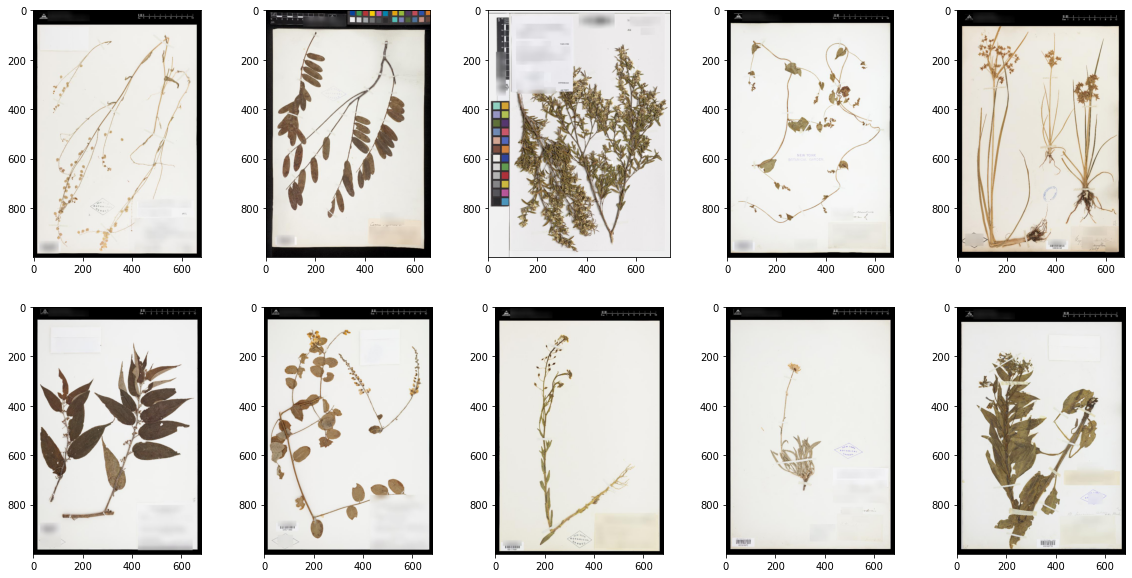

In [13]:
plt.figure(figsize=(20,10))
for i, x in enumerate(dataset.iloc[:10, 2]):
    im_path = BASEPATH / x
    with Image.open(im_path, 'r') as img:
        plt.subplot(2,5,i+1)
        plt.imshow(img)

# Image preprocessing

In [14]:
def preprocess_image(image_path=''):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [min_width, min_height])
    image /= 255.0
    
    return image

all_img_paths = dataset['file_name'].map(lambda x: str(BASEPATH/x))
all_labels = dataset['category_id']

# Create path tensor group
path_ds = tf.data.Dataset.from_tensor_slices(all_img_paths)
## Convert path tensor to 4dim tensor with pre-defined function
## path_ds(filepath tensor, 1D) -- map + preprocess_image --> 4dim tensor
image_ds = path_ds.map(preprocess_image, num_parallel_calls=-1)
labels = tf.data.Dataset.from_tensor_slices(tf.cast(all_labels, tf.float32))

# merge image_ds dataset with labels dataset
train = tf.data.Dataset.zip((image_ds, labels))

train = train.batch(32)
train = train.prefetch(buffer_size=-1)

# Baseline model

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, 3, activation='relu', input_shape=[min_width, min_height, 3]))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Conv2D(64, 3, activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Conv2D(64, 3, activation='relu'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(category_num, 'softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

history = model.fit(train, epochs=20)

Epoch 1/20
 2202/70555 [..............................] - ETA: 10:54:37 - loss: 10.7858 - accuracy: 2.5783e-04